In [ ]:
import pandas as pd 
import os
import numpy as np
import sys 
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import random
from sklearn.preprocessing import StandardScaler
import torch
import torchvision
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:


data1 =pd.read_csv('/home/juan/Documents/Master_Project/data/process/final_selection/datasets_to_choose/data1.csv')
data9 = pd.read_csv('/home/juan/Documents/Master_Project/data/process/final_selection/datasets_to_choose/data_1_test.csv')

df_1 = data1.iloc[:, 1:]
df_9 = data9.iloc[:,1:]

# Iterate through each DataFrame and merge 'internal_vdw' column from df_9
df_1 = pd.merge(df_1, df_9[['Folder', 'internal_vdw_energy']], on='Folder', how='inner')

columns = df_1.columns.tolist()

# Remove "Folder" and "QM/MM SP Barrier" from the list of columns
columns.remove("Folder")
columns.remove("QM/MM SP Barrier")

# Reorder the list of columns with "Folder" and "QM/MM SP Barrier" at the end
new_columns_order = columns + ["Folder", "QM/MM SP Barrier"]

# Reindex the DataFrame to reorder the columns
df_1 = df_1.reindex(columns=new_columns_order)
df_1.head()

In [ ]:
dataset_initial = pd.read_csv('/home/juan/Documents/Master_Project/data/process/initial/dataset.csv')
df = dataset_initial.iloc[:,1:]
data_all = pd.read_csv('/home/juan/Documents/Master_Project/data/process/dataset_ext_ALLB.csv')
df0 = data_all[df.columns]
df_0 = df0.merge(df_1[['Folder']], on='Folder', how='inner')
df_0.tail()

In [ ]:
dataset_initial = pd.read_csv('/home/juan/Documents/Master_Project/data/process/initial/dataset.csv')
df00 = dataset_initial.iloc[:,1:]
df00
df00.tail()


In [ ]:
df_9

In [ ]:
df = pd.read_csv('/home/juan/Documents/Master_Project/data/process/final_selection/All_feats_newC_hp_atoms.csv')
df = df.iloc[:, 1:]
df.head()

### Initial dataset

In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
# Import your custom TorchRandomForestRegressor
import sys
sys.path.append('/home/juan/Documents/Master_Project/code/my_work/Testing-Algorithms/')
from rf_improved2_copy import TorchRandomForestRegressor
import warnings
from sklearn.exceptions import DataConversionWarning
from tqdm import tqdm
def mean_deviation_from_true_mean(y_true, y_pred):
    """
    Calculates the mean of the absolute deviations of predicted values from the mean of true values.

    :param y_true: array-like, true values.
    :param y_pred: array-like, predicted values.
    :return: float, mean deviation from the true mean.
    """
    true_mean = np.mean(y_true)
    deviations = np.abs(y_pred - true_mean)
    mean_deviation = np.mean(deviations)
    return mean_deviation

def preprocess_data_manual_no_split(df, use_torch):
    X = df.drop(columns=['QM/MM SP Barrier', 'Folder']).values
    Y = df['QM/MM SP Barrier'].values
    ss = StandardScaler()
    Y_reshaped = Y.reshape(-1, 1)
    Y_normalized = ss.fit_transform(Y_reshaped)
    if use_torch:
        X = torch.tensor(X, dtype=torch.float32)
        Y_normalized = torch.tensor(Y_normalized, dtype=torch.float32).flatten()
    return X, Y_normalized, ss


def cross_validate_with_blind_set(X, y,feature_names, X_blind, y_blind=None, n_splits=10, use_torch=False):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    rmse_scores = []
    pearson_corr_scores = []
    deviations = []
    feature_importances = {name: [] for name in feature_names}  # Initialize feature importance dictionary

    # Suppress DataConversionWarnings
    warnings.filterwarnings(action='ignore', category=DataConversionWarning)
    
    # Initialize model
    if use_torch:
        model = TorchRandomForestRegressor(nb_trees=8, nb_samples=40, max_depth=200, bootstrap=True)
    else:
        model = RandomForestRegressor(
            n_estimators=160,
            criterion="squared_error",
            max_depth=30,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features=0.8,
            bootstrap=True,
            oob_score=True,
            n_jobs=-1,
            random_state=40,
            ccp_alpha=0.00,
            max_samples=None,
            monotonic_cst=None)
        '''
        svr_model = SVR(kernel='rbf',        # Non-linear kernel
                degree=3,            # Degree for the polynomial kernel. Irrelevant for the 'rbf' kernel.
                gamma='scale',       # Gamma value of 'scale' accounts for the number of features automatically.
                coef0=0.0,           # Independent term in kernel function, significant only in 'poly' and 'sigmoid'.
                tol=1e-3,            # Tolerance for stopping criterion.
                C=1.0,               # Regularization parameter.
                epsilon=0.1,         # Epsilon in the epsilon-SVR model.
                shrinking=True,      # Whether to use the shrinking heuristic.
                cache_size=200,      # Specify the size of the kernel cache (in MB).
                verbose=False,       # Enable verbose output.
                max_iter=-1)         # Hard limit on iterations within solver, or -1 for no limit.'''

    
    # Use tqdm for progress display
    for train_index, test_index in tqdm(kf.split(X), total=n_splits, desc="Cross-Validation"):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Ensure y_train is properly shaped for RandomForestRegressor
        y_train = y_train.ravel() if not use_torch else y_train

        # Fit the model
        if use_torch:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        
        # Ensure y_pred and y_test are flattened
        y_pred = y_pred.flatten() if hasattr(y_pred, 'flatten') else y_pred.view(-1)
        y_test = y_test.flatten() if hasattr(y_test, 'flatten') else y_test.view(-1)

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores.append(rmse)
        pearson_corr, _ = pearsonr(y_test, y_pred)
        pearson_corr_scores.append(pearson_corr)
        deviation = mean_deviation_from_true_mean(y_test, y_pred)
        deviations.append(deviation)
    # Restore warning behavior to default
    warnings.filterwarnings(action='default', category=DataConversionWarning)

    # Prepare for blind set prediction
    if use_torch:
        blind_set_predictions = model.predict(X_blind).flatten()  # Ensure it's flattened
    else:
        blind_set_predictions = model.predict(X_blind)
        importances = model.feature_importances_
        
    for name, importance in zip(feature_names, importances):
        feature_importances[name].append(importance)
    
    # Unstandardize predictions and actuals for plotting
    blind_set_rmse = None
    blind_pearson_corr = None
    if y_blind is not None:
        y_blind = y_blind.flatten()  # Ensure y_blind is flattened
        blind_set_rmse = np.sqrt(mean_squared_error(y_blind, blind_set_predictions))
        blind_pearson_corr, _ = pearsonr(y_blind, blind_set_predictions)

    return np.mean(rmse_scores), np.mean(pearson_corr_scores), np.mean(deviations), blind_set_predictions, blind_set_rmse, blind_pearson_corr, feature_importances

def plot_actual_vs_predicted(Y_actual, Y_predicted, pearson_corr, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(Y_actual, Y_predicted, color='Tomato', alpha=0.5)
    plt.plot(Y_actual, Y_actual, color='SteelBlue')
    plt.title(title)
    plt.xlabel('Actual Barriers')
    plt.ylabel('Predicted Barriers')
    plt.text(0.05, 0.95, f'Pearson Correlation: {pearson_corr:.3f}', transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    plt.show()

def complete_analysis_pipeline(df, title, use_torch=False):
    X, Y_normalized, ss = preprocess_data_manual_no_split(df, use_torch)
    # Splitting the dataset into training and blind sets
    train_percentage = 0.65
    n_samples = len(X)
    n_train_samples = int(train_percentage * n_samples)
    X_train, Y_train = X[:n_train_samples], Y_normalized[:n_train_samples]
    X_blind, Y_blind = X[n_train_samples:], Y_normalized[n_train_samples:]
    print(len(X_blind), len(Y_blind))
    mean_rmse, mean_pearson, mean_deviationn, blind_set_predictions, blind_set_rmse, blind_pearson_corr, feature_importances = cross_validate_with_blind_set(X_train, Y_train, X_blind, Y_blind, use_torch=use_torch)
    
    # Unstandardize predictions and actuals for plotting
    blind_true = ss.inverse_transform(Y_blind.reshape(-1, 1)).flatten()
    blind_pred = ss.inverse_transform(blind_set_predictions.reshape(-1, 1)).flatten()

    print(f"Mean RMSE: {mean_rmse}, Mean Pearson Correlation: {mean_pearson}, Blind Set RMSE: {blind_set_rmse}, Blind Pearson Correlation: {blind_pearson_corr}, Deviation: {mean_deviationn}")
    plot_actual_vs_predicted(blind_true, blind_pred, blind_pearson_corr, title)
    return feature_importances

In [ ]:

dataset_initial = pd.read_csv('/home/juan/Documents/Master_Project/data/process/initial/dataset.csv')
df = dataset_initial.iloc[:,1:]
data_all = pd.read_csv('/home/juan/Documents/Master_Project/data/process/dataset_ext_ALLB.csv')
df = data_all[df.columns]

data_multiv = pd.read_csv('/home/juan/Documents/Master_Project/data/process/dataset-09-03.csv')
df2 = data_multiv.iloc[:,1:]

lasso_rf = pd.read_csv('/home/juan/Documents/Master_Project/data/interim/lasso-rf-10-03.csv')
df3 = lasso_rf.iloc[:,1:]


data_multivariate = pd.read_csv('/home/juan/Documents/Master_Project/data/process/best_feats_multivariate.csv')
df4 = data_multivariate.iloc[:,1:]

data_simple = pd.read_csv('/home/juan/Documents/Master_Project/data/process/data_simple_featsS.csv')
df5 = data_simple.iloc[:,1:]

df6 = pd.read_csv('/home/juan/Documents/Master_Project/data/interim/data_simple_feats_MF.csv')
df6.head() 
df6 = df6.iloc[:,1:]
dff = pd.read_csv('/home/juan/Documents/Master_Project/data/interim/forces.csv')
dff= dff.iloc[:,1:]
merged_df = pd.merge(df6, dff, on='Folder', how='inner')
merged_df = merged_df[[col for col in merged_df.columns if col not in ['Folder', 'QM/MM SP Barrier']] + ['Folder', 'QM/MM SP Barrier']]
df_final =pd.read_csv('/home/juan/Documents/Master_Project/data/process/final_selection/all_data_simple_selection.csv')
df_final=df_final.iloc[:,1:]
df_final.head()

In [ ]:
def remove_big_outliers(df, column_name, threshold):
    """
    Remove values greater than a specified threshold from a specific column in the DataFrame.

    :param df: DataFrame containing the data
    :param column_name: Name of the column to remove outliers from
    :param threshold: Threshold value for removing outliers
    :return: DataFrame with outliers removed
    """
    # Remove rows with values greater than the threshold from the specified column
    df_no_outliers = df[df[column_name] <= threshold]
    
    return df_no_outliers

# Example usage:
# Assuming df_final is your DataFrame containing data
# Remove values greater than 40 from the column "QM/MM SP Barrier"
column_name = "QM/MM SP Barrier"
threshold = 40
df_no_outliers = remove_big_outliers(df_final, column_name, threshold)


In [ ]:
df_no_outliers

In [ ]:

# Split the data into training and testing sets
X = df3.drop(columns=['QM/MM SP Barrier', 'Folder'])  # Features
y = df3['QM/MM SP Barrier']  # Target variable

def manual_train_test_split(X, y, test_size=0.6, random_state=None):
    """
    Manually splits the dataset into training and testing sets.

    Parameters:
        X (array-like): The feature matrix.
        y (array-like): The target variable.
        test_size (float or int): The proportion of the dataset to include in the test split.
            If float, should be between 0.0 and 1.0.
            If int, represents the absolute number of test samples.
        random_state (int or None): Random seed for reproducibility. Default is None.

    Returns:
        array-like: The training features (X_train).
        array-like: The testing features (X_test).
        array-like: The training target (y_train).
        array-like: The testing target (y_test).
    """
    # Set random seed for reproducibility
    if random_state is not None:
        np.random.seed(random_state)
    
    # Shuffle the indices of the dataset
    n_samples = len(X)
    shuffled_indices = np.random.permutation(n_samples)
    
    # Calculate the number of samples for the test set
    if isinstance(test_size, float):
        test_size = int(test_size * n_samples)
    
    # Split the shuffled indices into training and testing indices
    test_indices = shuffled_indices[:test_size]
    train_indices = shuffled_indices[test_size:]
    
    # Create the training and testing sets
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    
    return X_train, X_test, y_train, y_test

# Example usage
# Assuming X and y are your feature matrix and target variable, respectively
X_train, X_test, y_train, y_test = manual_train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest regressor
rf_model = RandomForestRegressor(n_estimators=100, max_features='sqrt', max_depth=80, 
                                      min_samples_split=2, min_samples_leaf=2, bootstrap=True, 
                                      n_jobs=-1, verbose=0)
rf_model.fit(X_train, y_train)

# Make predictions on training and testing sets
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calculate mean squared error
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# Plot training set
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, color='blue', label='Training set')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Training Set: True vs Predicted Values (MSE = {:.2f})'.format(train_mse))
plt.legend()
plt.grid(True)
plt.show()

# Plot testing set
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='green', label='Testing set')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Testing Set: True vs Predicted Values (MSE = {:.2f})'.format(test_mse))
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Plot both training and testing sets on one plot
plt.figure(figsize=(8, 6))

# Plot training set
plt.scatter(y_train, y_train_pred, color='lightblue', label='Training set', alpha=0.8)

# Plot testing set
plt.scatter(y_test, y_test_pred, color='darkorange', label='Testing set', alpha=0.2)

# Plot diagonal line
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')

# Labels and title
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
dataset_initial = pd.read_csv('/home/juan/Documents/Master_Project/data/process/initial/dataset.csv')
df = dataset_initial.iloc[:,1:]
data_all = pd.read_csv('/home/juan/Documents/Master_Project/data/process/dataset_ext_ALLB.csv')
df0 = data_all[df.columns]
# Merge df_0 with df_1 based on the 'Folder' column
df_0 = df0.merge(df_1[['Folder']], on='Folder', how='inner')

In [ ]:
complete_analysis_pipeline(df,title='  ', use_torch=False)

In [ ]:
complete_analysis_pipeline(df00,title='  ', use_torch=False)

In [ ]:
complete_analysis_pipeline(df_9,title='  ', use_torch=False)

In [ ]:
complete_analysis_pipeline(df_0,title='  ', use_torch=False)

In [ ]:
complete_analysis_pipeline(df_1,title='  ', use_torch=False)

In [ ]:
complete_analysis_pipeline(df_no_outliers,title='  ', use_torch=False)

In [ ]:
complete_analysis_pipeline(df,title='  ', use_torch=False)

In [ ]:
complete_analysis_pipeline(df2,title='', use_torch=False)


In [ ]:
complete_analysis_pipeline(df3,title=' ', use_torch=False)


In [ ]:
complete_analysis_pipeline(df4,title='', use_torch=False)


In [ ]:
complete_analysis_pipeline(df5,title='', use_torch=False)


In [ ]:
complete_analysis_pipeline(df6,title='', use_torch=False)


In [ ]:
complete_analysis_pipeline(merged_df,title='', use_torch=False)


In [ ]:
import numpy as np

def manual_train_test_split(X, y, test_size=0.2):
    """
    Manually split the dataset into training and testing sets.
    
    :param X: Features (numpy array).
    :param y: Target variable (numpy array).
    :param test_size: Proportion of the dataset to include in the test split.
    :return: X_train, X_test, y_train, y_test
    """
    # Determine the number of data points
    num_data = X.shape[0]
    
    # Shuffle the data indices
    indices = np.arange(num_data)
    np.random.shuffle(indices)
    
    # Split indices for training and testing
    split_idx = int(num_data * (1 - test_size))
    train_idx, test_idx = indices[:split_idx], indices[split_idx:]
    
    # Create the training and testing sets
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    return X_train, X_test, y_train, y_test
x,y,ss = preprocess_data_manual_no_split(df6, use_torch=False)

X_train, X_test, y_train, y_test = manual_train_test_split(x, y, test_size=0.4)

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.optimizers import Adam

def build_model(input_shape):
    model = Sequential()
    
    # First LSTM layer with Dropout
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    # Second LSTM Layer
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    # Dense Layer for prediction
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))  # Use 'sigmoid' for binary classification, 'softmax' for multi-class

    return model

# Assuming X_train is your input features with shape (n_samples, seq_length, n_features)
# For gene expression data, seq_length would typically be 1, making this a typical dense network layout.
X_train_reshaped = np.expand_dims(X_train, axis=1) # This will make the shape (num_samples, 1, num_features)
input_shape = (1, X_train.shape[1])

model = build_model(input_shape)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',  # 'categorical_crossentropy' for multi-class
              metrics=['accuracy'])

# Model summary
model.summary()

# Fit the model
# Assuming the rest of your code remains the same
history = model.fit(X_train_reshaped, y_train, 
                    epochs=50, 
                    batch_size=64, 
                    validation_split=0.2,
                    verbose=1)

# Note: You should also include callbacks like ModelCheckpoint and EarlyStopping for better training control


In [ ]:
import tensorflow as tf

if tf.test.gpu_device_name():
    print("Default GPU Device: {}".format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


In [ ]:

def complete_analysis_pipeline(df, title, use_torch=False):
    feature_names = df.drop(columns=['QM/MM SP Barrier', 'Folder']).columns.tolist()
    X, Y_normalized, ss = preprocess_data_manual_no_split(df, use_torch)
    
    # Splitting the dataset into training and blind sets
    train_percentage = 0.65
    n_samples = len(X)
    n_train_samples = int(train_percentage * n_samples)
    X_train, Y_train = X[:n_train_samples], Y_normalized[:n_train_samples]
    X_blind, Y_blind = X[n_train_samples:], Y_normalized[n_train_samples:]

    mean_rmse, mean_pearson, mean_deviation, blind_set_predictions, blind_set_rmse, blind_pearson_corr, feature_importances = cross_validate_with_blind_set(X_train, Y_train, X_blind, Y_blind, use_torch=use_torch, feature_names=feature_names)
    
    # Unstandardize predictions and actuals for plotting
    blind_true = ss.inverse_transform(Y_blind.reshape(-1, 1)).flatten()
    blind_pred = ss.inverse_transform(blind_set_predictions.reshape(-1, 1)).flatten()

    print(f"Mean RMSE: {mean_rmse}, Mean Pearson Correlation: {mean_pearson}, Blind Set RMSE: {blind_set_rmse}, Blind Pearson Correlation: {blind_pearson_corr}, Deviation: {mean_deviation}")
    for feature, importances in feature_importances.items():
        print(f"{feature}: {np.mean(importances)}")
    plot_actual_vs_predicted(blind_true, blind_pred, blind_pearson_corr, title)


In [ ]:

def complete_analysis_pipeline(df, title, use_torch=False):
    feature_names = df.drop(columns=['QM/MM SP Barrier', 'Folder']).columns.tolist()
    X, Y_normalized, ss = preprocess_data_manual_no_split(df, use_torch)
    
    # Splitting the dataset into training and blind sets
    train_percentage = 0.65
    n_samples = len(X)
    n_train_samples = int(train_percentage * n_samples)
    X_train, Y_train = X[:n_train_samples], Y_normalized[:n_train_samples]
    X_blind, Y_blind = X[n_train_samples:], Y_normalized[n_train_samples:]

    mean_rmse, mean_pearson, mean_deviation, blind_set_predictions, blind_set_rmse, blind_pearson_corr, feature_importances = cross_validate_with_blind_set(X_train, Y_train, feature_names,  X_blind, Y_blind, use_torch=use_torch)
    
    # Unstandardize predictions and actuals for plotting
    blind_true = ss.inverse_transform(Y_blind.reshape(-1, 1)).flatten()
    blind_pred = ss.inverse_transform(blind_set_predictions.reshape(-1, 1)).flatten()

    print(f"Mean RMSE: {mean_rmse}, Mean Pearson Correlation: {mean_pearson}, Blind Set RMSE: {blind_set_rmse}, Blind Pearson Correlation: {blind_pearson_corr}, Deviation: {mean_deviation}")
    for feature, importances in feature_importances.items():
        print(f"{feature}: {np.mean(importances)}")
    plot_actual_vs_predicted(blind_true, blind_pred, blind_pearson_corr, title)
    return feature_importances

In [ ]:
df.head()

In [ ]:
feats2 = complete_analysis_pipeline(df, ' ', use_torch=False)

In [ ]:
feats = complete_analysis_pipeline(df_9, ' ', use_torch=False)

In [ ]:
import matplotlib.pyplot as plt

# Transpose the feature_importances to organize by training rather than by feature
trainings_transposed = list(zip(*feats.values()))

# Plotting
plt.figure(figsize=(50, 20))  # Further increased figure size for clarity
for i, training in enumerate(trainings_transposed):
    plt.plot(list(feats.keys()), training, marker='o', label=f'Training {i+1}')

plt.title('Feature Importances Across Trainings', fontsize=30)  # Further increased title font size
plt.xlabel('Features', fontsize=24)  # Further increased x-axis label font size
plt.ylabel('Importance', fontsize=24)  # Further increased y-axis label font size
plt.xticks(rotation=90, fontsize=19)  # Rotated to 90 degrees and decreased font size
plt.yticks(fontsize=20)  # Further increased y-axis tick label font size
plt.legend(fontsize=20, loc='upper right')  # Increased legend font size and moved to avoid blocking the plot
plt.subplots_adjust(bottom=0.5)  # Adjusted bottom spacing to accommodate rotated x labels
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Assuming 'feats' is a dictionary with feature names as keys and lists of importances as values

# Filter out features with zero importance across all trainings
non_zero_feats = {feature: importances for feature, importances in feats.items() if any(importance > 0 for importance in importances)}

# Transpose the feature_importances to organize by training rather than by feature
trainings_transposed = list(zip(*feats.values()))
feature_names = list(feats.keys())

# Plotting
plt.figure(figsize=(10, len(feature_names) * 0.3))  # Adjusted vertical size based on the number of features
for i, training in enumerate(trainings_transposed):
    plt.plot(training, range(len(feature_names)), marker='o', linestyle='-', label=f'Training {i+1} Fold')

plt.title('Feature Importances Across Trainings', fontsize=20)
plt.xlabel('Importance', fontsize=16)
plt.yticks(range(len(feature_names)), feature_names, fontsize=16)
plt.xticks(fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, axis='x')

# Improve layout and spacing
plt.tight_layout()
plt.gca().invert_yaxis()  # Invert y-axis so the features are listed top-down
plt.subplots_adjust(left=0.2, bottom=0.1, top=0.95)  # Adjust spacing to accommodate feature names and titles

plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Transpose the feature_importances to organize by training rather than by feature
trainings_transposed = list(zip(*feats.values()))

# Plotting
plt.figure(figsize=(20, 50))  # Adjusted figure size for vertical orientation
for i, training in enumerate(trainings_transposed):
    plt.barh(range(len(list(feats.keys()))), training, label=f'Training {i+1}')

plt.title('Feature Importances Across Trainings', fontsize=30)  # Adjusted title font size
plt.ylabel('Features', fontsize=24)  # Adjusted y-axis label (now for features) font size
plt.xlabel('Importance', fontsize=24)  # Adjusted x-axis label (now for importances) font size
plt.yticks(range(len(list(feats.keys()))), list(feats.keys()), fontsize=12)  # Adjusted feature name font size
plt.xticks(fontsize=20)  # Adjusted importance value font size
plt.legend(fontsize=20, loc='lower right')  # Adjusted legend font size and location
plt.tight_layout()
plt.grid(True)  # Added grid for better readability of values
plt.show()


In [ ]:
featsT = complete_analysis_pipeline(df, ' ', use_torch=False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the average importance for each feature
average_importances = {feature: np.mean(importances) for feature, importances in featsT.items()}

# Identify the threshold for the top 10% features based on average importance
threshold_value = np.quantile(list(average_importances.values()), 0.90)

# Select only the top 10% features based on the threshold, maintaining their original order
top_featsT = {feature: importances for feature, importances in featsT.items() if average_importances[feature] >= threshold_value}

# Since we want to plot all trainings without ordering the features by importance, 
# we maintain the original feature ordering but limit to top 10% features
selected_features = [feature for feature in featsT if feature in top_featsT]

# Calculate the average importance of the selected top 10% features for plotting
average_top_importances = [np.mean(featsT[feature]) for feature in selected_features]

# Plotting
plt.figure(figsize=(10, 24))  # Adjust the figure size to better fit the vertical orientation
plt.barh(selected_features, average_top_importances, color='slateblue')

plt.title('Average Importances of Top 10% Features Across All Trainings', fontsize=20)  # Increase title font size
plt.xlabel('Average Importance', fontsize=16)  # Increase x-axis label font size
plt.ylabel('Features', fontsize=16)  # Increase y-axis label font size
plt.xticks(fontsize=14)  # Increase x-axis tick font size
plt.yticks(fontsize=14)  # Increase y-axis tick font size

plt.tight_layout()
plt.show()


In [ ]:
# Calculate the average importance for each feature
average_importances = {feature: np.mean(importances) for feature, importances in featsT.items()}

# Identify the threshold for the top 10% features based on average importance
threshold_value = np.quantile(list(average_importances.values()), 0.90)

# Select only the top 10% features based on the threshold, maintaining their original order
top_featsT = {feature: importances for feature, importances in featsT.items() if average_importances[feature] >= threshold_value}

# Define criteria for identifying newly added features:
# A feature is considered 'newly added' if it doesn't represent an entire number and
# starts with "resid" or "resname".
def is_new_feature(feature):
    return not feature.isdigit() or (feature.startswith('resid') or feature.startswith('resname'))

# Filter the top 10% features to find those that are newly added
newly_added_top_features = [feature for feature in top_featsT if is_new_feature(feature)]

# Calculate the percentage of newly added features in the top 10%
percentage_new_features = (len(newly_added_top_features) / len(top_featsT)) * 100

print(f"Percentage of newly added features in the top 10%: {percentage_new_features:.2f}%")


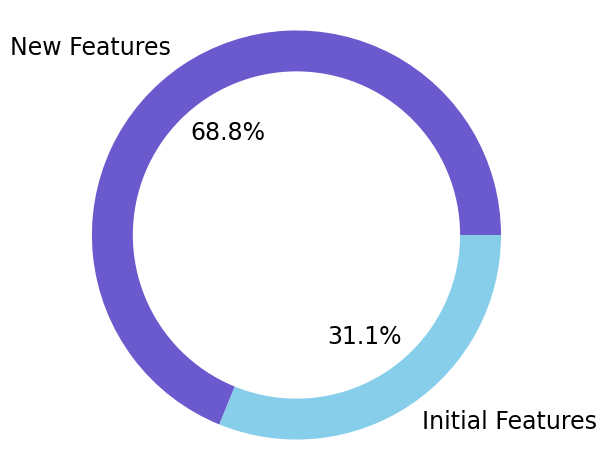

In [2]:
import matplotlib.pyplot as plt

# Proportion of features added by you within the top 10%
features_added_by_you = 68.85
features_not_added_by_you = 100 - 68.85

# Pie chart labels and sizes
labels = ['New Features', 'Initial Features']
sizes = [features_added_by_you, features_not_added_by_you]

# Colors for the pie chart slices
colors = ['slateblue', 'skyblue']  # Adjusted to match your preference

# Create subplots
fig1, ax1 = plt.subplots()

# Plot the pie chart
wedges, texts, autotexts = ax1.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=0)

# Draw a circle at the center
centre_circle = plt.Circle((0, 0), 0.80, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Set text size for labels and percentages
for text in texts:
    text.set_fontsize(17)
for autotext in autotexts:
    autotext.set_fontsize(17)


# Aspect ratio and layout
ax1.axis('equal')  
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the average importance for each feature
average_importances = {feature: np.mean(importances) for feature, importances in featsT.items()}

# Sort features by their average importance in descending order and select the top 20
top_features = sorted(average_importances.items(), key=lambda x: x[1], reverse=True)[:20]

# Extracting just the feature names for the selected top 20 features
selected_features = [feature for feature, _ in top_features]

# Extracting the average importances for the selected top 20 features for plotting
average_top_importances = [average_importances[feature] for feature in selected_features]

# Plotting
plt.figure(figsize=(15, 10))  # Adjust the figure size for a clear view of the top 20 features
plt.bar(selected_features, average_top_importances, color='slateblue')

plt.ylabel('Average Importance', fontsize=21)  # Adjust for vertical orientation
plt.xticks(rotation=80, fontsize=19)  # Rotate feature names for clarity
plt.yticks(fontsize=22)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the average importance for each feature
average_importances = {feature: np.mean(importances) for feature, importances in featsT.items()}

# Sort features by their average importance in descending order and select the top 30
top_features = sorted(average_importances.items(), key=lambda x: x[1], reverse=True)[:20]

# Extracting just the feature names for the selected top 30 features
selected_features = [feature for feature, _ in top_features]

# Extracting the average importances for the selected top 30 features for plotting
average_top_importances = [average_importances[feature] for feature in selected_features]

# Plotting
plt.figure(figsize=(12, 15))  # Adjust the figure size for a clear view of the top 30 features
plt.barh(selected_features[::-1], average_top_importances[::-1], color='slateblue')  # Reverse the lists to have the highest on top

plt.title('Average Importances of Top 20 Features Across All Trainings', fontsize=25)
plt.xlabel('Average Importance', fontsize=21)
plt.xticks(fontsize=19)
plt.yticks(fontsize=22)

plt.tight_layout()
plt.show()
